In [13]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

model = ChatOpenAI(model="gpt-4o")

result = model.invoke("What is the capital of France?")



In [15]:
search_tool = TavilySearchResults(max_results = 3)

tools = [search_tool]

memory = MemorySaver()



In [17]:
llm_with_tools = model.bind_tools(tools=tools)

In [18]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

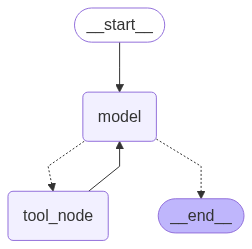

In [19]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [20]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="Tell me in detailed about James Webb Telescope and how it is used to study the universe")], 
}, config=config)

response

{'messages': [HumanMessage(content='Tell me in detailed about James Webb Telescope and how it is used to study the universe', additional_kwargs={}, response_metadata={}, id='88018199-e504-40b6-b2f4-185f5aa45ca3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_27uzA4v2P0XP2HsmVmGuTkMP', 'function': {'arguments': '{"query":"James Webb Space Telescope overview and usage"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 96, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a3b1f6d-be73-4541-b61f-94c215d6b41a-0', tool_calls=[{'name': 'tavily_search_resu

In [21]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="Tell me in detailed about James Webb Telescope and how it is used to study the universe")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me in detailed about James Webb Telescope and how it is used to study the universe', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '9bc69ee6-24bc-4057-a847-353d99412432', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me in detailed about James Webb Telescope and how it is used to study the universe', additional_kwargs={}, response_metadata={})]}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '5c886a0b-2dec-4016-87fe-f34444d6a342', 'metadata': {'thread_id': 8, 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ('__start__',), 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:4ba9eea1-2583-cb1b-69ee-2eb11f308fbc'}, 'parent_ids': ['9bc69ee6-24bc-4057-a847-353d99412432']}
{'event':

In [22]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="Tell me in detailed about James Webb Telescope and how it is used to study the universe")],
}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

The James Webb Space Telescope (JWST) is one of the most advanced and powerful astronomical observatories ever constructed. It is designed to explore the universe in unprecedented detail and address some of the most fundamental questions in astronomy and cosmology. Here’s a detailed look at the JWST and its scientific goals:

### Overview and Development:
- **Launch Date**: JWST was successfully launched on December 25, 2021.
- **Agencies Involved**: It is a collaboration among NASA, the European Space Agency (ESA), and the Canadian Space Agency (CSA).
- **Orbital Position**: The telescope orbits around the second Lagrange point (L2), which is approximately 1.5 million kilometers from Earth. This position allows it to maintain a stable environment with minimal interference from Earth’s heat and light.

### Technical Specifications:
- **Primary Mirror**: The JWST's primary mirror is 6.5 meters in diameter, composed of 18 hexagonal segments made from beryllium and coated with a thin laye